In [53]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
import astropy
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz
from skycam_utils.photometry import load_skycam_catalog
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

In [2]:
skycat = load_skycam_catalog()
srccat = Table.read("sources.csv")
srccat.rename_column('id', 'Star Name')
srccat

<Table length=41>
  Star Name       xcentroid      ...  background_mean         obs_mag      
    str13          float64       ...      float64             float64      
------------- ------------------ ... ------------------ -------------------
         Vega  222.3164812942366 ... 31.968597003361868  -9.235415739832995
     Arcturus    443.95375849222 ... 27.750194660449814  -9.148126171931652
       Altair 148.94000517196793 ...  40.11278635938662  -8.968435430182664
      Antares 353.88248716486027 ... 32.235836879674814   -8.86202977939444
        Deneb 158.27048337332877 ...  38.63624080083091  -8.662341072804331
   Rasalhague 270.51894694854406 ...  33.04995128973374  -8.497885834895541
        Mizar 399.20899718837865 ... 27.360504525816896  -8.322986037721128
       Alkaid 403.91984359726297 ...  26.15807034699153  -8.277264073440353
   Rasalgethi  288.8677555321391 ... 32.832542787925775  -8.195740520228185
  Pulcherrima  410.4117015566291 ... 27.620476638801676  -8.175532137240607
          ...                ... ...                ...                 ...
      Shelyak 209.15194805194804 ...  34.90703449807427  -7.216226812931205
       Phecda 430.97300944669365 ...  27.78352481819722   -7.17454551994832
      Edasich 337.05874125874124 ...    26.830985420188  -7.135765104502702
      Pherkad  319.0461760461761 ... 27.791523811569487  -7.101833086529517
       Altais 240.98338368580062 ... 29.252516269110952   -7.05214497359925
      Tarazed 152.68996960486322 ...  45.24343374690761 -7.0455647340348895
        Merak  428.8201550387597 ...  29.16181242455266  -7.023899286588168
    Alderamin  192.1390977443609 ...  32.86386508491419  -6.814779080737621
Yed Posterior  353.6924528301887 ... 30.254640982883725 -6.8106896740019724
       Nekkar 378.30223123732253 ... 27.285378054780356  -6.732117298193075

In [4]:
hdul = fits.open("image_0007410.fits")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
EXTEND  =                    T                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
UT      = 'MON JUN 22 05:52:27 2020'                                            
LST     = '16:32:25.045'                                                        
AZ      =         225.87537099                                                  
EL      =          48.88659478                                                  
SCOPEX  =                  3

In [5]:
dt = datetime.datetime.strptime(hdr['UT'], "%a %b %d %H:%M:%S %Y")
tobs = Time(dt, scale='utc')
tobs

<Time object: scale='utc' format='datetime' value=2020-06-22 05:52:27>

In [6]:
skycat = update_altaz(skycat, time=tobs)

In [7]:
joint = join(skycat, srccat, keys='Star Name', join_type='inner')
joint.keep_columns(['Star Name', 'Identity', 'xcentroid', 'ycentroid', 'Magnitude', 'obs_mag', 'background_mean', 'RA', 'Dec', 'Alt', 'Az'])
joint.sort('Magnitude')
joint

<Table length=41>
  Star Name           Identity        ...  background_mean         obs_mag      
                                      ...                                       
    str17              str25          ...      float64             float64      
------------- ----------------------- ... ------------------ -------------------
     Arcturus            Alpha Bodtis ... 27.750194660449814  -9.148126171931652
         Vega             Alpha Lyrae ... 31.968597003361868  -9.235415739832995
       Altair           Alpha Aquilae ...  40.11278635938662  -8.968435430182664
      Antares           Alpha Scorpii ... 32.235836879674814   -8.86202977939444
        Deneb             Alpha Cygni ...  38.63624080083091  -8.662341072804331
       Shaula          Lambda Scorpii ...  41.69086596814034  -7.497826353218428
       Alioth   Epsilon Ursae Majoris ... 27.291824951710897  -8.133345013315266
        Dubhe     Alpha Ursae Majoris ... 29.069945450874815  -7.963146913241463
       Alkaid       Eta Ursae Majoris ...  26.15807034699153  -8.277264073440353
          ...                     ... ...                ...                 ...
   Cor Caroli Alpha Canem Venaticorum ... 27.025578685936594  -7.309404902071751
      Pherkad     Gamma Ursae Minoris ... 27.791523811569487  -7.101833086529517
       Altais          Delta Draconis ... 29.252516269110952   -7.05214497359925
      Albireo              Beta Cygni ...  43.01471727381167  -7.535250803799052
        Sarin          Delta Herculis ... 30.487746720465665 -7.3324520548079954
Yed Posterior        Epsilon Ophiuchi ... 30.254640982883725 -6.8106896740019724
      Edasich           Iota Draconis ...    26.830985420188  -7.135765104502702
      Shelyak              Beta Lyrae ...  34.90703449807427  -7.216226812931205
   Rasalgethi          Alpha Herculis ... 32.832542787925775  -8.195740520228185
       Nekkar             Beta Bodtis ... 27.285378054780356  -6.732117298193075

In [8]:
wcs_initial = WCS("../2019/wcs.fits")

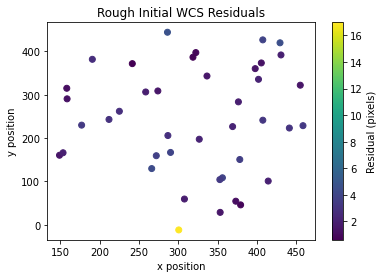

In [9]:
fit_x, fit_y = wcs_initial.all_world2pix(joint['Az'], joint['Alt'], 0)
resid_d = ((fit_x-joint['xcentroid'])**2+(fit_y-joint['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [11]:
resid_d[resid_d < 10].mean()

2.438012483490123

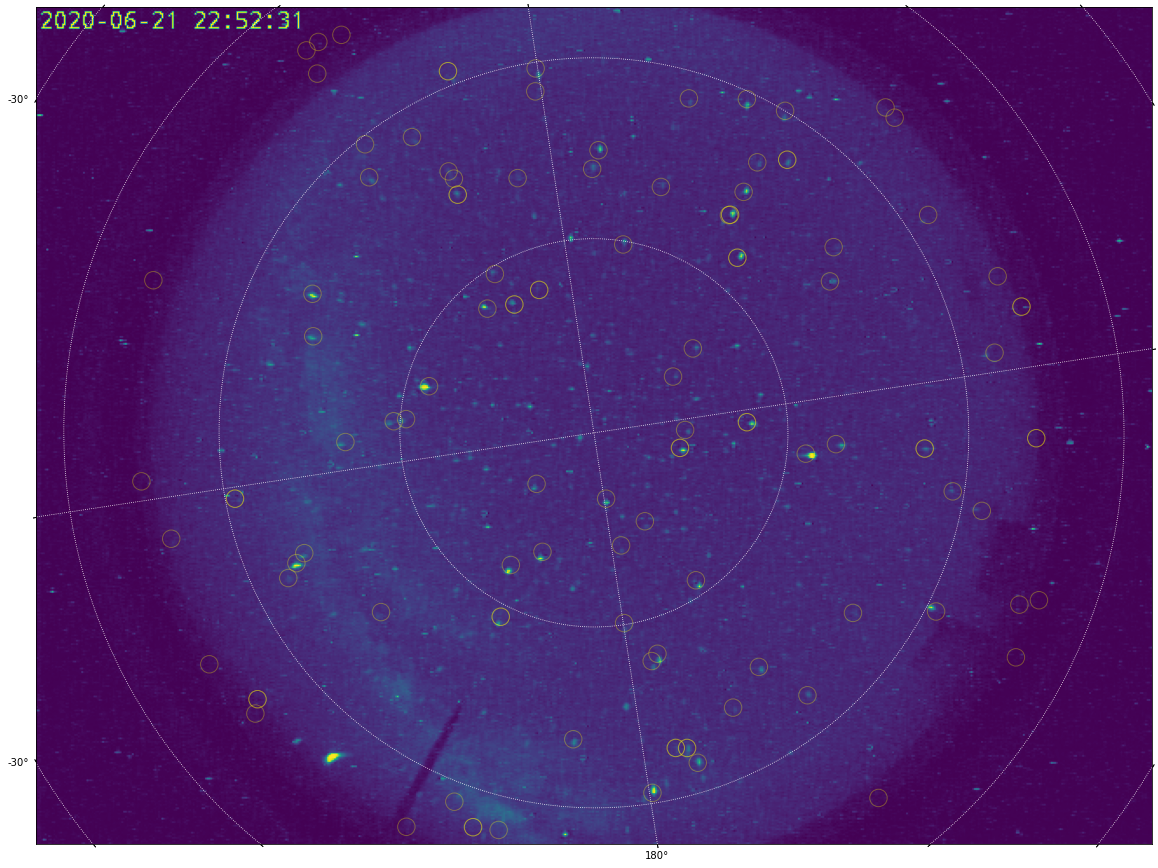

In [28]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
#aps.plot(color='red', lw=1.5, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()

In [12]:
joint.write("astrometry.csv")

In [13]:
joint2019 = Table.read("../2019/astrometry.csv")

In [20]:
two_years = vstack([joint, joint2019])

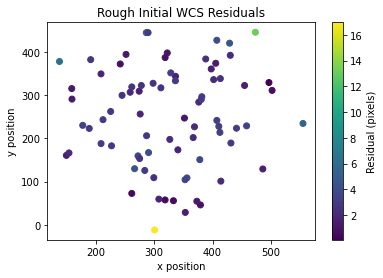

In [21]:
fit_x, fit_y = wcs_initial.all_world2pix(two_years['Az'], two_years['Alt'], 0)
resid_d = ((fit_x-two_years['xcentroid'])**2+(fit_y-two_years['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [23]:
resid_d[resid_d < 10].mean()

2.416961273380799

In [29]:
wcs_initial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 320.62668221556  236.19084807882  
PC1_1 PC1_2  : 0.28502705073499  0.043994506459906  
PC2_1 PC2_2  : -0.04038542897814  0.26750500846492  
CDELT : 0.92468348821396  0.98423634712595  
NAXIS : 0  0

In [38]:
fun = wcs_zea(two_years['xcentroid'], two_years['ycentroid'], two_years['Alt'], two_years['Az'], crpix1=321, crpix2=236, a_order=2, b_order=2)
init = np.array([324, 235, 1, 1, 0.3, 0.003, 0.003, 0.3])
sip_init = np.zeros(18)
x0 = np.append(init, sip_init)
#x0 = init
fit_result = minimize(fun, x0)
wcs_refined = fun.return_wcs(fit_result.x)
wcs_refined

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 336.98101577723907  248.0616249834887  
PC1_1 PC1_2  : 0.2415536741626009  0.05735028397876812  
PC2_1 PC2_2  : -0.1022942305784001  0.24366505187217746  
CDELT : 1.117876399737312  1.0479743028405217  
NAXIS : 0  0

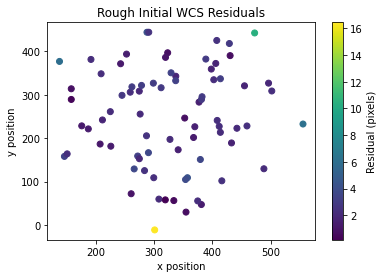

2.3007220586159525

In [39]:
fit_x, fit_y = wcs_refined.all_world2pix(two_years['Az'], two_years['Alt'], 0)
resid_d = ((fit_x-two_years['xcentroid'])**2+(fit_y-two_years['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()
resid_d[resid_d < 10].mean()

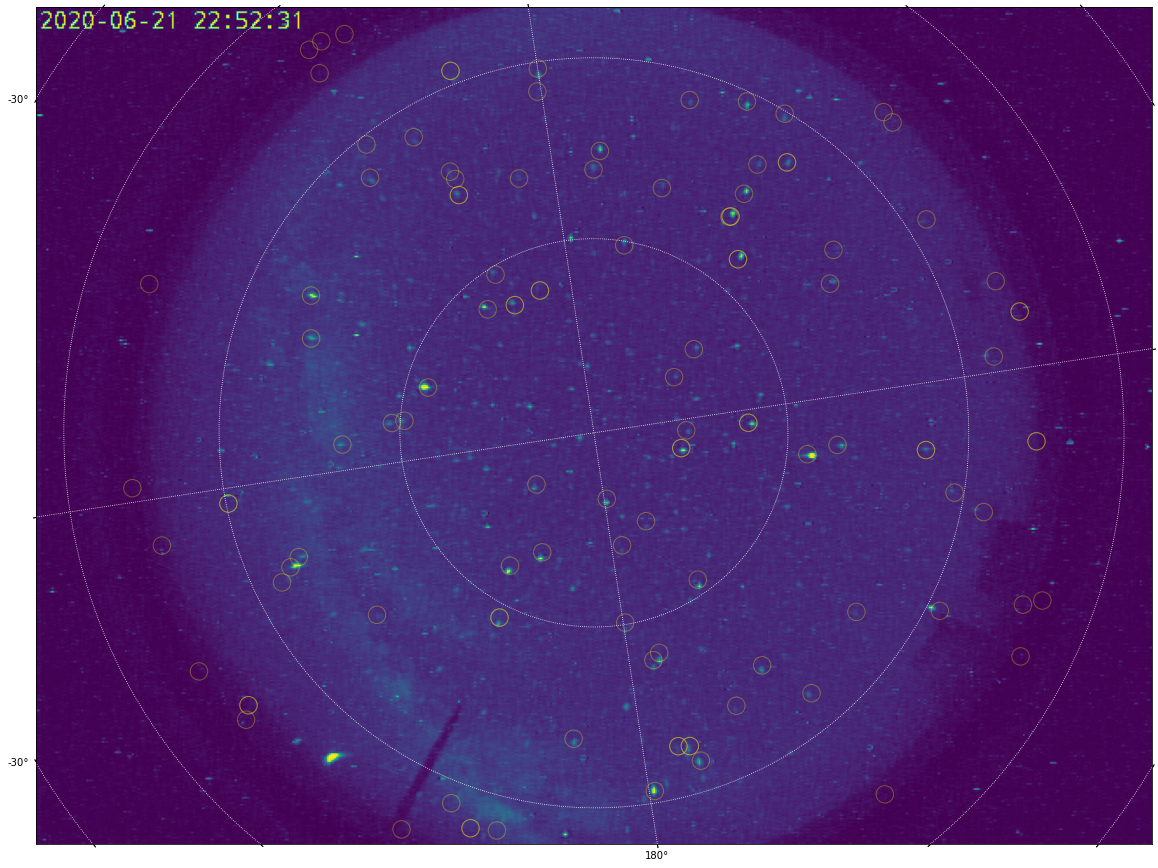

In [48]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
pred_x, pred_y = wcs_refined.all_world2pix(skycat['Az'], skycat['Alt'], 0)
init_x, init_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
init_aps = CircularAperture((init_x, init_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
#init_aps.plot(color='red', lw=1, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()

In [43]:
wcs_refined.to_header_string()

"WCSAXES =                    2 / Number of coordinate axes                      CRPIX1  =      336.98101577724 / Pixel coordinate of reference point            CRPIX2  =      248.06162498349 / Pixel coordinate of reference point            PC1_1   =      0.2415536741626 / Coordinate transformation matrix element       PC1_2   =    0.057350283978768 / Coordinate transformation matrix element       PC2_1   =     -0.1022942305784 / Coordinate transformation matrix element       PC2_2   =     0.24366505187218 / Coordinate transformation matrix element       CDELT1  =      1.1178763997373 / [deg] Coordinate increment at reference point  CDELT2  =      1.0479743028405 / [deg] Coordinate increment at reference point  CUNIT1  = 'deg'                / Units of coordinate increment and value        CUNIT2  = 'deg'                / Units of coordinate increment and value        CTYPE1  = 'RA---ZEA'           / TAN (gnomonic) projection + SIP distortions    CTYPE2  = 'DEC--ZEA'           / TAN (g

In [57]:
new_hdr = wcs_refined.to_header( relax=0x80000)

In [58]:
new_hdr

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      336.98101577724 / Pixel coordinate of reference point            
CRPIX2  =      248.06162498349 / Pixel coordinate of reference point            
PC1_1   =      0.2415536741626 / Coordinate transformation matrix element       
PC1_2   =    0.057350283978768 / Coordinate transformation matrix element       
PC2_1   =     -0.1022942305784 / Coordinate transformation matrix element       
PC2_2   =     0.24366505187218 / Coordinate transformation matrix element       
CDELT1  =      1.1178763997373 / [deg] Coordinate increment at reference point  
CDELT2  =      1.0479743028405 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---ZEA-SIP'       / TAN (gnomonic) projection + SIP distortions    
CTYPE2  = 'DEC--ZEA-SIP'    

In [62]:
newhdu = fits.PrimaryHDU(header=new_hdr)
newhdu.writeto("wcs_refined.fits")

In [63]:
test = WCS("wcs_refined.fits")

In [64]:
test

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 336.98101577724  248.06162498349  
PC1_1 PC1_2  : 0.2415536741626  0.057350283978768  
PC2_1 PC2_2  : -0.1022942305784  0.24366505187218  
CDELT : 1.1178763997373  1.0479743028405  
NAXIS : 0  0

In [65]:
test.has_distortion

True